In [ ]:

notebook = "PhaseField/surfing_jupyter_notebook/surfing_pyvista.ipynb"
author = "Mostafa Mollaali, Keita Yoshioka"
date = "2022-06-28"
title = "Surfing boundary"
weight = 158
[menu]
  [menu.benchmarks]
    parent = "Phase-Field"
<!--eofm-->

In [9]:
from ogs6py import ogs

In [10]:
import os
import ogs6py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import time
import re
import vtuIO
from IPython.display import Image
import pyvista as pv
from pyvista import examples
from scipy.spatial import Delaunay

In [11]:
## Install vtuIO
#!/usr/local/opt/python@3.9/bin/python3.9 -m pip install  https://github.com/joergbuchwald/VTUinterface/archive/refs/heads/master.zip

## Install PyVista
#!/usr/local/opt/python@3.9/bin/python3.9 -m pip install pyvista

## Install OGS6py
# pip install [--user] https://github.com/joergbuchwald/ogs6py/archive/refs/heads/master.zip

## Problem description

Consider a plate, $\Omega=[0,2]\times [-0.5,0.5]$, with an explicit edge crack, $\Gamma=[0,0.5]\times \{0\}$; that is subjected  to a time dependent crack opening displacement:

\begin{eqnarray}
	\label{eq:surfing_bc}
	\mathbf{u}(x,y,t)= \mathbf{U}(x-\text{v}t,y) \quad \text{on} \quad \partial\Omega_D,
\end{eqnarray}
where $\text{v}$ is an imposed loading velocity; and $\mathbf{U}$ is the asymptotic solution for the Mode-I crack opening displacement
\begin{eqnarray}
	\label{eq:asymptotic}
	U_x= \dfrac{K_I}{2\mu} \sqrt{\dfrac{r}{2\pi}} (\kappa-\cos \varphi) \cos \frac{\varphi}{2}, \nonumber
	\\
	U_y= \dfrac{K_I}{2\mu} \sqrt{\dfrac{r}{2\pi}} (\kappa-\cos \varphi) \sin \frac{\varphi}{2},
\end{eqnarray}


where $K_I$ is the stress intensity factor, $\kappa=(3-\nu)/(1+\nu)$ and $\mu=E / 2  (1 + \nu) $; $(r,\varphi)$ are the polar coordinate system,  where the origin is crack tip.
Also, we used $G_\mathrm{c}=K_{Ic}^2(1-\nu^2)/E$ as the fracture surface energy under plane strain condition.
Table 1 lists the material properties and geometry of the numerical model.

![Schematic view of surfing boundary condition benchmark](./figures/surfing_schematic.png#one-half "Schematic view of surfing boundary condition benchmark.")

# Input Data


<!-- <head>
    <style type='text/css'>
        table.test { border-collapse: collapse; }
        table.test td { border-bottom: 1px solid black; }
    </style>
</head>
<center>
<body>
        <table class='test'>
        <caption> Table 1: Surfing boundary example: Material properties  and geometrical  parameters.</caption>
        <tr style="border-bottom:2px solid black">
          <td colspan="100%"></td>
        </tr>
        <tr>
            <td >Name</td>
            <td>Symbol</td>
            <td style="width:40%">Value      </td>
            <td>Unit</td>
        </tr>
        <tr style="border-bottom:2px solid black">
          <td colspan="100%"></td>
        </tr>
        <tr>
            <td>Young's modulus</td>
            <td>$E$</td>
            <td>210 $\times 10^3$</td>
            <td>MPa</td>
        </tr>
        <tr>
            <td>Critical energy release rate </td>
            <td>$G_{c}$</td>
            <td>2.7</td>
            <td>MPa$\cdot$mm</td>
        </tr>
        <tr>
            <td>Poisson's ratio</td>
            <td>$\nu$</td>
            <td>0.3</td>
            <td>$-$</td>
        </tr>
        <tr>
            <td>Effective element size</td>
            <td>$h$</td>
            <td>$5 \times 10^{-3}$</td>
            <td>mm</td>
        </tr>
        <tr>
            <td>Regularization parameter</td>
            <td>$\ell_s$</td>
            <td>$1\times10^{-2}$</td>
            <td>mm</td>
        </tr>
        <tr>
            <td>Imposed loading velocity</td>
            <td>$\text{v}$</td>
            <td>1.5</td>
            <td>mm/s</td>
        </tr>
        <tr>
            <td>Length</td>
            <td>$L$</td>
            <td>$2$</td>
            <td>mm</td>
        </tr>
        <tr>
            <td>Height</td>
            <td>$H$</td>
            <td>$1$</td>
            <td>mm</td>
        </tr>
        <tr>
            <td>Initial crack length</td>
            <td>$a_0$</td>
            <td>$0.5$</td>
            <td>mm</td>
        </tr>
        <tr style="border-bottom:2px solid black">
          <td colspan="100%"></td>
        </tr>
    </table>
</body>
</center> -->

| **Name**                       | **Value**          | **Unit**     | **Symbol** |
|--------------------------------|--------------------|--------------|------------|
| _Young's modulus_              | 210x$10^3$  | MPa          | $E$        |
| _Critical energy release rate_ | 2.7                | MPa$\cdot$mm | $G_{c}$    |
| _Poisson's ratio_              | 0.3                | $-$          | $\nu$      |
| _Regularization parameter_     | 2$h$   | mm           | $\ell_s$   |
| _Imposed loading velocity_     | 1.5                | mm/s         | $\text{v}$ |
| _Length_                       | $2$                | mm           | $L$        |
| _Height_                       | $1$                | mm           | $H$        |
| _Initial crack length_         | $0.5$              | mm           | $a_0$      |

In [18]:
x_tip_Initial=0.5
y_tip_Initial=0.5
Height  =1.

Orientation=0
h = 0.05
G_i = 2.7
ls = 2*h
# We set ls=2h in our simulation
phasefield_model='AT1'# AT1 and AT2 

## Paths and project file name

In [19]:
#OGS
# To run this example, OGS must be compiled with PETSc and Python.
# CC=mpicc CXX=mpic++ cmake ../ogs/ -G Ninja -DCMAKE_BUILD_TYPE=Release -DOGS_USE_PETSC=ON -DOGS_USE_PYTHON=ON

# file's name
prj_path='./'
prj_name = "surfing.prj"

# Mesh generation

In [20]:
# https://www.opengeosys.org/docs/tools/meshing/structured-mesh-generation/
!{"generateStructuredMesh"} -o surfing_quad_1x2.vtu -e quad --lx 2 --nx {round(2/h)+1} --ly 1 --ny {round(1/h)+1}
!{"NodeReordering"} -i surfing_quad_1x2.vtu -o surfing_quad_1x2_NR.vtu

[2022-06-27 23:39:17.888] [ogs] [info] Mesh created: 924 nodes, 861 elements.
[2022-06-27 23:39:18.096] [ogs] [info] Reordering nodes... 
[2022-06-27 23:39:18.097] [ogs] [info] Corrected 0 elements.
[2022-06-27 23:39:18.100] [ogs] [info] VTU file written.


# Pre-processing 
At fracture, we set the initial phase field to zero.

In [21]:
mesh = pv.read("./surfing_quad_1x2_NR.vtu")
phase_field = np.ones((len(mesh.points),1))
pv.set_plot_theme("document")


for node_id, x in enumerate(mesh.points):
    if x[0]< x_tip_Initial+h/10  and x[1] < Height/2+h and x[1] > Height/2-h:
        phase_field[node_id] = 0.0
        
mesh.point_data['pf-ic'] = phase_field
mesh.save('surfing_quad_1x2_NR_pf_ic.vtu')
mesh
# cpos = mesh.plot()

pf_ic = mesh.point_data["pf-ic"]
sargs=dict(title='pf-ic', title_font_size=20, label_font_size=15, n_labels=5,
               position_x=0.3, position_y=0.2, fmt="%.1f", width=.5)
clim=[0, 1.]

p = pv.Plotter(shape=(1, 1), border=False)
p.add_mesh(mesh, scalars = pf_ic,
               show_edges=True, show_scalar_bar=True,
               colormap="coolwarm", clim=clim,
               scalar_bar_args=sargs)

p.view_xy()
p.window_size = [800,800]
p.show()

ViewInteractiveWidget(height=800, layout=Layout(height='auto', width='100%'), width=800)

# Run the simulation 

In [22]:
#https://github.com/joergbuchwald/ogs6py
#Change the length scale and phasefield model in project file
model = ogs.OGS(INPUT_FILE=prj_path+prj_name, PROJECT_FILE=prj_path+prj_name, MKL=True)
model.replace_parameter(name="ls", value=2*h)
model.replace_text(phasefield_model, xpath="./processes/process/phasefield_model")
model.write_input()

True

In [24]:
isExist = os.path.exists("./results")
if not isExist: 
      os.makedirs("./results")


t0 = time.time()
print(">>> OGS started execution ... <<<")
!{"ogs"} {prj_path+prj_name} -o results > log

tf = time.time()
print(">>> OGS terminated execution  <<< Elapsed time: ", round(tf - t0, 2), " s.")

>>> OGS started execution ... <<<
>>> OGS terminated execution  <<< Elapsed time:  22.7  s.


# Results

We computed the energy release rate using $G_{\theta}$ method (Destuynder _et al._, 1983; Li _et al._, 2016)  and plot the errors against the theoretical numerical toughness i.e. $(G_c^{\text{eff}})_{\texttt{num}}=G_c(1+\frac{h}{2\ell})$ for $\texttt{AT}_2$,
and $(G_c^{\text{eff}})_{\texttt{num}}=G_c(1+\frac{3h}{8\ell})$ for $\texttt{AT}_1$ (Bourdin _et al._, 2008).

![Alt text](./figures/surfing_gtheta_schematic.png#one-half "Phase field and $\theta$ profile  for the volumetric deviatoric $\texttt{AT}_2$ models.  We use virtual perturbation of $\theta$ to compute energy release rate using $G_{\theta}$ Dubois et al., 1998. The  $\theta$ value is 1 inside of $B_{r_{in}}(P)$,  0 outside, and a linear interpolation in between. We set $r_{in}=4\ell$ and $r_{out}=2.5r_{in}$ (see Li et al., 2016).")

In [25]:
R_inn=4*ls
R_out=2.5*R_inn

if phasefield_model=='AT1':
    G_eff=G_i*(1+3*h/(8*ls))
elif phasefield_model=='AT2':
    G_eff= G_i*(1+h/(2*ls))

We run the simulation with a coarse mesh here to reduce computing time; however, a finer mesh would give a more accurate results. The energy release rate and its error for Models $\texttt{AT}_1$ and $\texttt{AT}_2$ with a mesh size of $h=0.005$ are shown below.

![Alt text](./figures/surfing_gtheta_ref.png#one-half)
![Alt text](./figures/surfing_gtheta_error_ref.png#one-half)

# Post-processing

In [26]:
reader = pv.get_reader("./results/surfing.pvd")
plotter = pv.Plotter(notebook=False, off_screen=False)
G_theta_time = np.zeros((len(reader.time_values),2))


for t, time_value in enumerate(reader.time_values):
    reader.set_active_time_value(time_value)

    mesh = reader.read()[0] 
    points = mesh.point_data["phasefield"].shape[0]
    xs = mesh.points[:,0]
    ys = mesh.points[:,1]
    pf = mesh.point_data["phasefield"]
    sigma = mesh.point_data["sigma"]
    disp = mesh.point_data["displacement"]

    num_points = disp.shape
    theta = np.zeros(num_points) 
    
    #--------------------------------------------------------------------------------
    # find fracture tip
    #-------------------------------------------------------------------------------- 
    min_pf=min(pf[:])
    coord_pf_0p5=mesh.points[pf<0.5]
    if   min_pf <= 0.5:
                coord_pf_0p5[np.argmax(coord_pf_0p5, axis=0)[0]][1]
                x0=coord_pf_0p5[np.argmax(coord_pf_0p5, axis=0)[0]][0]
                y0=coord_pf_0p5[np.argmax(coord_pf_0p5, axis=0)[0]][1]
    else:
                x0=x_tip_Initial 
                y0=y_tip_Initial
    Crack_position = [x0,y0]    
    #--------------------------------------------------------------------------------
    #define \theta
    #--------------------------------------------------------------------------------
    for i, x in enumerate(mesh.points):
        # distance from the crack tip
        R = np.sqrt((x[0] - Crack_position[0])**2 + (x[1] - Crack_position[1])**2)
        if R < R_inn:
            theta_funct = 1.0
        elif R > R_out:
            theta_funct = 0.0
        else:
            theta_funct = (R-R_out)/(R_inn-R_out)
        theta[i][0] = theta_funct * np.cos(Orientation)
        theta[i][1] = theta_funct * np.sin(Orientation)

    mesh.point_data['theta'] = theta

    #--------------------------------------------------------------------------------
    #define grad \theta
    #--------------------------------------------------------------------------------
    mesh_theta = mesh.compute_derivative(scalars="theta")
    mesh_theta["gradient"]
    def gradients_to_dict(arr):
        """A helper method to label the gradients into a dictionary."""
        keys = np.array(["thetax_x", "thetax_y", "thetax_z", "thetay_x", "thetay_y", "thetay_z"])
        keys = keys.reshape((2, 3))[:, : arr.shape[1]].ravel()
        return dict(zip(keys, mesh_theta["gradient"].T))


    gradients_theta = gradients_to_dict(mesh_theta["gradient"])
    mesh.point_data.update(gradients_theta)
    #--------------------------------------------------------------------------------
    #define grad u
    #--------------------------------------------------------------------------------
    mesh_u = mesh.compute_derivative(scalars="displacement")
    mesh_u["gradient"]
    def gradients_to_dict(arr):
        """A helper method to label the gradients into a dictionary."""
        keys = np.array(
            ["Ux_x", "Ux_y", "Ux_z", "Uy_x", "Uy_y", "Uy_z"])
        keys = keys.reshape((2, 3))[:, : arr.shape[1]].ravel()
        return dict(zip(keys, mesh_u["gradient"].T))

    # a=np.array([1,2,3,4,5,6])
    # np.reshape(a.ravel(), (2, 3))
    gradients_u = gradients_to_dict(mesh_u["gradient"])
    # gradients
    mesh.point_data.update(gradients_u)

    #--------------------------------------------------------------------------------
    #define G_theta
    #--------------------------------------------------------------------------------
    G_theta_i = np.zeros(num_points[0])
    sigma = mesh.point_data["sigma"]
    Ux_x = mesh.point_data["Ux_x"]
    Ux_y = mesh.point_data["Ux_y"]
    Uy_x = mesh.point_data["Uy_x"]
    Uy_y = mesh.point_data["Uy_y"]

    thetax_x = mesh.point_data["thetax_x"]
    thetax_y = mesh.point_data["thetax_y"]
    thetay_x = mesh.point_data["thetay_x"]
    thetay_y = mesh.point_data["thetay_y"]

    for i, x in enumerate(mesh.points):
        #---------------------------------------------------------------------------
        sigma_xx = sigma[i][0]
        sigma_yy = sigma[i][1]
        sigma_xy = sigma[i][3]


        Ux_x_i = Ux_x[i]
        Ux_y_i = Ux_y[i]
        Uy_x_i = Uy_x[i]
        Uy_y_i = Uy_y[i]

        thetax_x_i = thetax_x[i]
        thetax_y_i = thetax_y[i]
        thetay_x_i = thetay_x[i]
        thetay_y_i = thetay_y[i]
        #---------------------------------------------------------------------------
        dUdTheta_11 = Ux_x_i*thetax_x_i + Ux_y_i*thetay_x_i
        dUdTheta_12 = Ux_x_i*thetax_y_i + Ux_y_i*thetay_y_i
        dUdTheta_21 = Uy_x_i*thetax_x_i + Uy_y_i*thetay_x_i
        dUdTheta_22 = Uy_x_i*thetax_y_i + Uy_y_i*thetay_y_i
        trace_sigma_grad_u_grad_theta = sigma_xx*dUdTheta_11 + sigma_xy*(dUdTheta_12 + dUdTheta_21) + sigma_yy*dUdTheta_22
        trace_sigma_grad_u = sigma_xx*Ux_x_i + sigma_xy*(Uy_x_i + Ux_y_i) + sigma_yy*Uy_y_i
        div_theta_i = thetax_x_i + thetay_y_i
        G_theta_i[i] = trace_sigma_grad_u_grad_theta - 0.5*trace_sigma_grad_u*div_theta_i
    mesh.point_data['G_theta_node'] = G_theta_i 
    #--------------------------------------------------------------------------------
    #Integral G_theta
    #--------------------------------------------------------------------------------    
    X = mesh.points[:,0]
    Y = mesh.points[:,1]
    G_theta_i = mesh.point_data["G_theta_node"]

    domain_points = np.array(list(zip(X,Y)))
    tri = Delaunay(domain_points)

    def area_from_3_points(x, y, z):
        return np.sqrt(np.sum(np.cross(x-y, x-z), axis=-1)**2)/2
    
    G_theta = 0
    for vertices in tri.simplices:
        mean_value = (G_theta_i[vertices[0]] + G_theta_i[vertices[1]] + G_theta_i[vertices[2]]) / 3
        area = area_from_3_points(domain_points[vertices[0]], domain_points[vertices[1]], domain_points[vertices[2]])
        G_theta += mean_value*area
    G_theta_time[t][1]= G_theta
    G_theta_time[t][0]= time_value
mesh.save('surfing_Post_Processing.vtu')  

## Plots

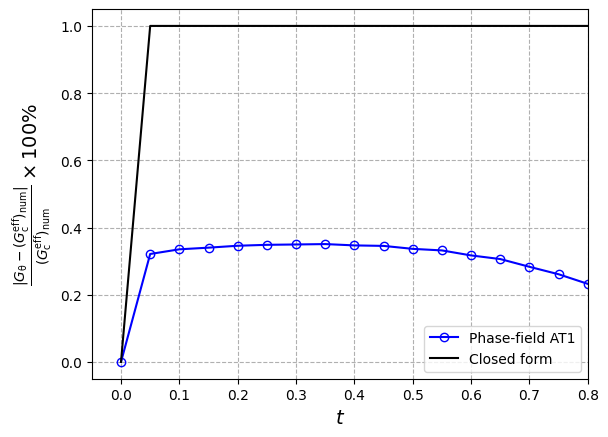

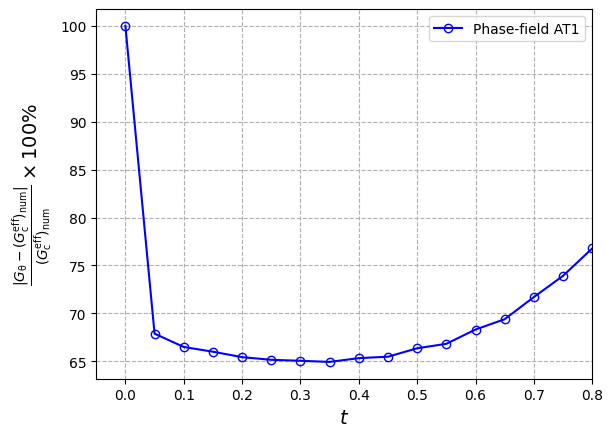

In [27]:
plt.xlabel('$t$',fontsize =14)
plt.ylabel(r'$\frac{|{G}_\mathrm{\theta}-({G}_\mathrm{c}^{\mathrm{eff}})_\mathrm{num}|}{({G}_\mathrm{c}^{\mathrm{eff}})_\mathrm{num}}\times 100\%$',fontsize=14)         
plt.plot(G_theta_time[:,0], abs(G_theta_time[:,1])/G_eff, '-ob',fillstyle='none' ,linewidth=1.5,label='Phase-field %s'%phasefield_model)
plt.plot(G_theta_time[:,0], np.append(0, np.ones(len(G_theta_time[:,0])-1)), '-k',fillstyle='none' ,linewidth=1.5,label='Closed form')               
plt.grid(linestyle='dashed') 
plt.xlim(-0.05,0.8)
legend = plt.legend(loc='lower right')
plt.savefig('./figures/G_theta_GcEff.png')
plt.show()




plt.xlabel('$t$',fontsize =14)
plt.ylabel(r'$\frac{|{G}_\mathrm{\theta}-({G}_\mathrm{c}^{\mathrm{eff}})_\mathrm{num}|}{({G}_\mathrm{c}^{\mathrm{eff}})_\mathrm{num}}\times 100\%$',fontsize=14)         
plt.plot(G_theta_time[:,0], abs(G_theta_time[:,1]-G_eff)/G_eff*100, '-ob',fillstyle='none' ,linewidth=1.5,label='Phase-field %s'%phasefield_model )
plt.grid(linestyle='dashed') 
plt.xlim(-0.05,0.8)
# plt.ylim(0,4)
legend = plt.legend(loc='upper right')
plt.savefig('./figures/G_theta_GcEff_error.png')
plt.show()

Hint: Accurate results can be obtained by using the mesh size below 0.02.

## Phase field profile 

### Fracture propagation animation

In [29]:
reader = pv.get_reader("./results/surfing.pvd")
plotter = pv.Plotter(notebook=False, off_screen=False)
# Open a gif
plotter.open_gif("figures/surfing.gif")
pv.set_plot_theme("document")
for time_value in reader.time_values:
    reader.set_active_time_value(time_value)
    mesh = reader.read()[0]  # This dataset only has 1 block
    
    sargs=dict(title='Phase field', title_font_size=20, label_font_size=15, n_labels=5,
               position_x=0.3, position_y=0.2, fmt="%.1f", width=.5)
    clim=[0, 1.]
    points = mesh.point_data["phasefield"].shape[0]
    xs = mesh.points[:,0]
    ys = mesh.points[:,1]
    pf = mesh.point_data["phasefield"]
    plotter.add_mesh(mesh, scalars=pf, show_scalar_bar=False, colormap="coolwarm", clim=clim,
               scalar_bar_args=sargs, lighting=False)
    plotter.add_text(f"Time: {time_value:.0f}", color="black")
    plotter.store_image = True

    plotter.view_xy()
    # Write a frame. This triggers a render.
    plotter.write_frame()
# Closes and finalizes movie
plotter.close()

### Phase field profile at last time step

In [30]:
mesh = reader.read()[0]
points = mesh.point_data["phasefield"].shape[0]
xs = mesh.points[:, 0]
ys = mesh.points[:, 1]
pf = mesh.point_data["phasefield"]

pv.set_plot_theme("document")
sargs = dict(
    title="Phase field",
    title_font_size=20,
    label_font_size=15,
    n_labels=5,
    position_x=0.3,
    position_y=0.2,
    fmt="%.1f",
    width=0.5,
)
clim = [0, 1.0]

p = pv.Plotter(shape=(1, 1), border=False)
p.add_mesh(
    mesh,
    scalars=pf,
    show_edges=False,
    show_scalar_bar=True,
    colormap="coolwarm",
    clim=clim,
    scalar_bar_args=sargs,
)

p.view_xy()
p.window_size = [800, 800]
p.show()


ViewInteractiveWidget(height=800, layout=Layout(height='auto', width='100%'), width=800)

## References

[1] B. Bourdin,  G.A. Francfort,  and J.-J. Marigo, _The  variational  approach  to  fracture_,  Journal of Elasticity **91** (2008), no. 1-3, 5–148.

[2]  Li, Tianyi, Jean-Jacques Marigo, Daniel Guilbaud, and Serguei Potapov. _Numerical investigation of dynamic brittle fracture via gradient damage models._ Advanced Modeling and Simulation in Engineering Sciences **3**, no. 1 (2016): 1-24.

[3]  Dubois, Frédéric and Chazal, Claude and
Petit, Christophe, _A  Finite  Element  Analysis  of  Creep-Crack  Growth  in Viscoelastic Media_, Mechanics Time-Dependent Materials **2** (1998), no. 3, 269–286